Version 2 10/2/2023  
Pipeline to process MERSCOPE experiments as they come in.  
Want to organize sections with only relevant metadata from new services and have ability to attach analysis status.  
To do this, trying out a SpatialDataset Class that will hold this information and could be made into a dashboard.  

The pipeline has the following basic steps:  
1. Pull metadata from new services
2. Assessment of total counts and corrlation to bulkseq
3. Re-segmentation 
4. QC of cells and filtering out low quality ones
5. Creation of AnnData object for primary analysis
6. Mapping with scrattch-mapping
7. First stage analysis of mapping  

This notebook should be able to run by providing the MERSCOPE barcode 

In [5]:
barcode = 1291813638
broad_region = 'Basal Ganglia'

In [1]:
import os, sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import importlib
from pathlib import Path
import sawg
from sawg import spatial_dataset as spd

from sawg import ScrattchMapping
from sawg import SpotTable
from sawg import MERSCOPESection

In [8]:
merscope_section = spd.MERSCOPESection(barcode)

UnboundLocalError: local variable 'spec_data_collection' referenced before assignment

In [4]:
merscope_section.broad_region = broad_region
merscope_section.save_dataset()

1. Load detected transcripts, calculate total counts, and correlate to bulk-seq. Look at some marker genes and zoom in for
sanity check

Loading from npz..


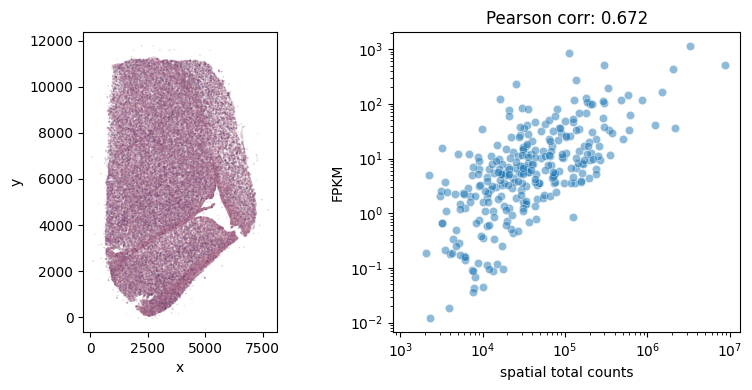

In [5]:
merscope_section.spatial_corr_to_bulk()

Loading from npz..


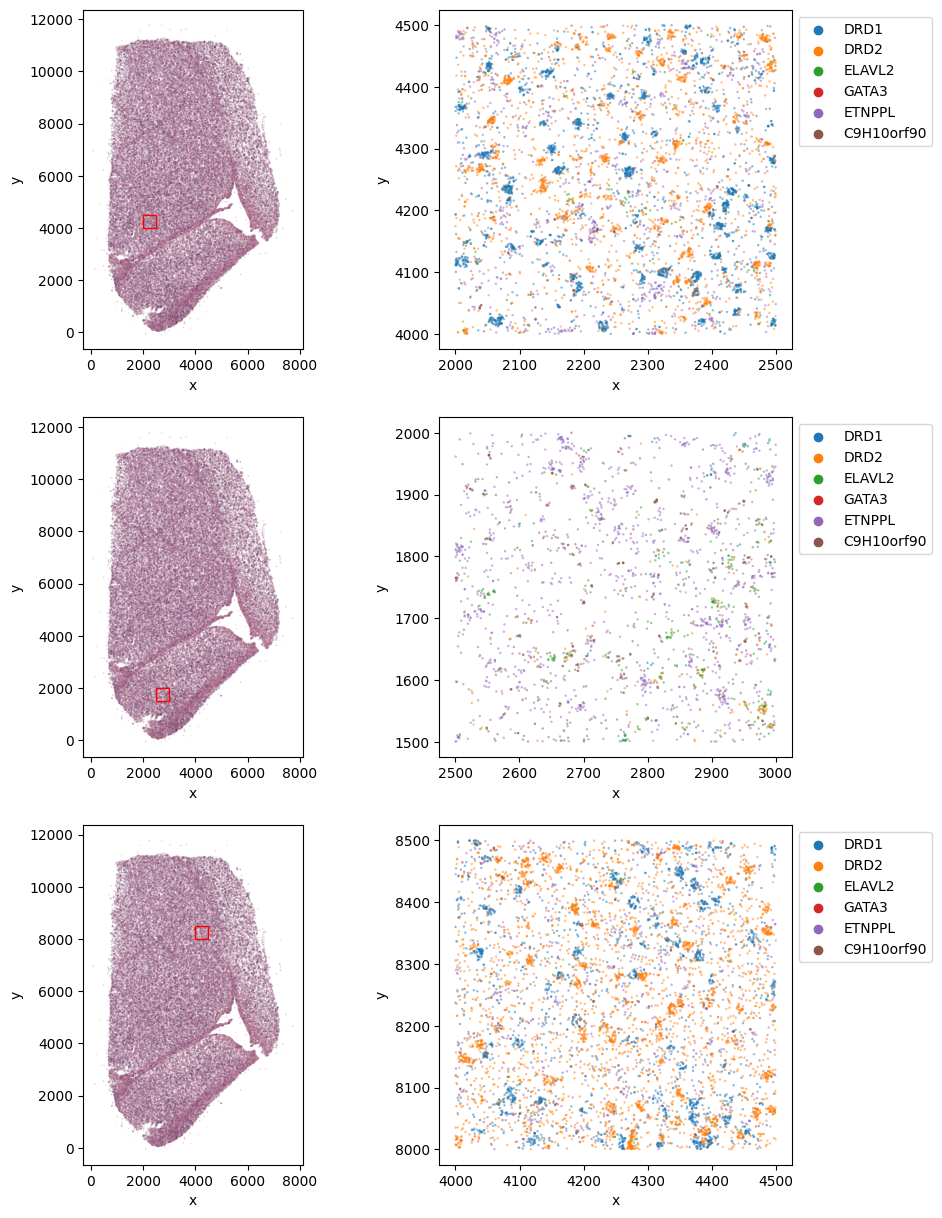

In [10]:
genes = ['DRD1', 'DRD2', 'ELAVL2', 'GATA3', 'ETNPPL', 'C9H10orf90']  
subregions = [
    ((2000, 2500), (4000, 4500)),
    ((2500, 3000), (1500, 2000)),
    ((4000, 4500), (8000, 8500))
]

merscope_section.show_gene_transcripts(genes=genes, subregions=subregions)

2. Resegment cells
- Load Segmentation Class
- Run model of choice
- Save results

In [4]:
merscope_section.check_segmentation_status()

{'20231130_132557': False,
 '20231130_132929': False,
 '20231130_133302': True,
 '20231130_133932': True,
 '2D': True}

In [5]:
subrgn = 'DAPI'
path_to_model = '/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/models/cellpose_20230919_3species_merscope'
seg_method = sawg.segmentation.CellposeSegmentationMethod
seg_opts = dict(options={
    'region': None,
    'cellpose_model': path_to_model,
    'cellpose_gpu': 'auto',
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um
    'z_plane_thickness': 1.5,  # um
    'images': {
        'cyto': {'channel': 'total_mrna', 'n_planes': 7}, 
        'nuclei': {'channel': 'DAPI'}
    }, 
    'cellpose_options': {
        'batch_size': 8,
        'min_size': 5000
    },
})
hpc_opts = {
    'conda_env': '/home/madeleine.hewitt/miniconda3/envs/seg_demo/',
    'hpc_host': 'hpc-login'  # change to 'hpc-login' if running locally
}

In [6]:
# To run a new segmentation:
spot_table, cbg = merscope_section.run_segmentation_on_section(subrgn, seg_method, seg_opts, hpc_opts)

# To load an existing segmentation (using a timestamp):
# spot_table, cell_by_gene = merscope_section.load_segmentation_results('2D')

Segmentation output directory: \\allen\programs\celltypes\workgroups\rnaseqanalysis\NHP_spatial\MERSCOPE\macaque\1291814104\segmentation\20231130_135123
Loading from npz..
Tiling segmentation region...


  0%|          | 0/71 [00:00<?, ?it/s]

Generated segmentation spec for 2718 tiles


  0%|          | 0/2718 [00:00<?, ?it/s]

Submitted: 10 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 0
Submitted: 10 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 0
Submitted: 14 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 4
Submitted: 16 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 6
Submitted: 21 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 12
Submitted: 24 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 14
Submitted: 27 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 17
Submitted: 32 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 23
Submitted: 36 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 26
Submitted: 40 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 30
Submitted: 42 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 32
Submitted: 48 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 38
Submitted: 50 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 40
Submitted: 54 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 44
Submitted: 61 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 51
Submitted: 62 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 52
Submitted: 65 / 2718 Status:

Submitted: 506 / 2718 Status: {'CG': 1, 'NO': 2708, 'R': 9} Saved: 497
Submitted: 510 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 500
Submitted: 515 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 505
Submitted: 519 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 509
Submitted: 522 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 512
Submitted: 528 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 518
Submitted: 531 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 521
Submitted: 534 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 524
Submitted: 536 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 530
Submitted: 543 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 533
Submitted: 545 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 535
Submitted: 549 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 539
Submitted: 555 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 545
Submitted: 558 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 548
Submitted: 560 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 550
Submitted: 568 / 2718 Status: {'NO': 2708, 'R':

Submitted: 1024 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1015
Submitted: 1025 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1015
Submitted: 1030 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1021
Submitted: 1035 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1025
Submitted: 1038 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1028
Submitted: 1043 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1033
Submitted: 1047 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1038
Submitted: 1052 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1042
Submitted: 1055 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1045
Submitted: 1058 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1048
Submitted: 1064 / 2718 Status: {'CG': 1, 'NO': 2708, 'R': 9} Saved: 1055
Submitted: 1067 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1057
Submitted: 1070 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1060
Submitted: 1077 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1067
Submitted: 1078 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1069
Submitted: 1083 /

Submitted: 1521 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1512
Submitted: 1525 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1516
Submitted: 1530 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1522
Submitted: 1534 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1524
Submitted: 1537 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1529
Submitted: 1540 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1531
Submitted: 1545 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1535
Submitted: 1550 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1541
Submitted: 1552 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1542
Submitted: 1560 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1550
Submitted: 1564 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1554
Submitted: 1566 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1556
Submitted: 1573 / 2718 Status: {'CG': 1, 'NO': 2708, 'R': 9} Saved: 1563
Submitted: 1576 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1566
Submitted: 1579 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 1569
Submitted: 1585 /

Submitted: 2072 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2062
Submitted: 2074 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2065
Submitted: 2079 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2069
Submitted: 2084 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2074
Submitted: 2087 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2077
Submitted: 2092 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2082
Submitted: 2098 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2088
Submitted: 2099 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2089
Submitted: 2106 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2096
Submitted: 2108 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2098
Submitted: 2112 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2104
Submitted: 2116 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2106
Submitted: 2121 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2111
Submitted: 2125 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2115
Submitted: 2127 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2117
Submitted: 2133 / 2718 St

Submitted: 2587 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2577
Submitted: 2588 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2578
Submitted: 2592 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2583
Submitted: 2597 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2588
Submitted: 2602 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2592
Submitted: 2603 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2593
Submitted: 2612 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2602
Submitted: 2613 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2603
Submitted: 2619 / 2718 Status: {'CG': 1, 'NO': 2708, 'R': 9} Saved: 2610
Submitted: 2623 / 2718 Status: {'CG': 1, 'NO': 2708, 'R': 9} Saved: 2614
Submitted: 2627 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2617
Submitted: 2635 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2626
Submitted: 2638 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2628
Submitted: 2643 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2633
Submitted: 2649 / 2718 Status: {'NO': 2708, 'R': 10} Saved: 2639
Submitted

  0%|          | 0/2718 [00:00<?, ?it/s]

Generating cell x gene table...
Counting genes...


  0%|          | 0/18367953 [00:00<?, ?it/s]

Generating sparse matrix...


  0%|          | 0/78132 [00:00<?, ?it/s]

Calculating cell centroids...


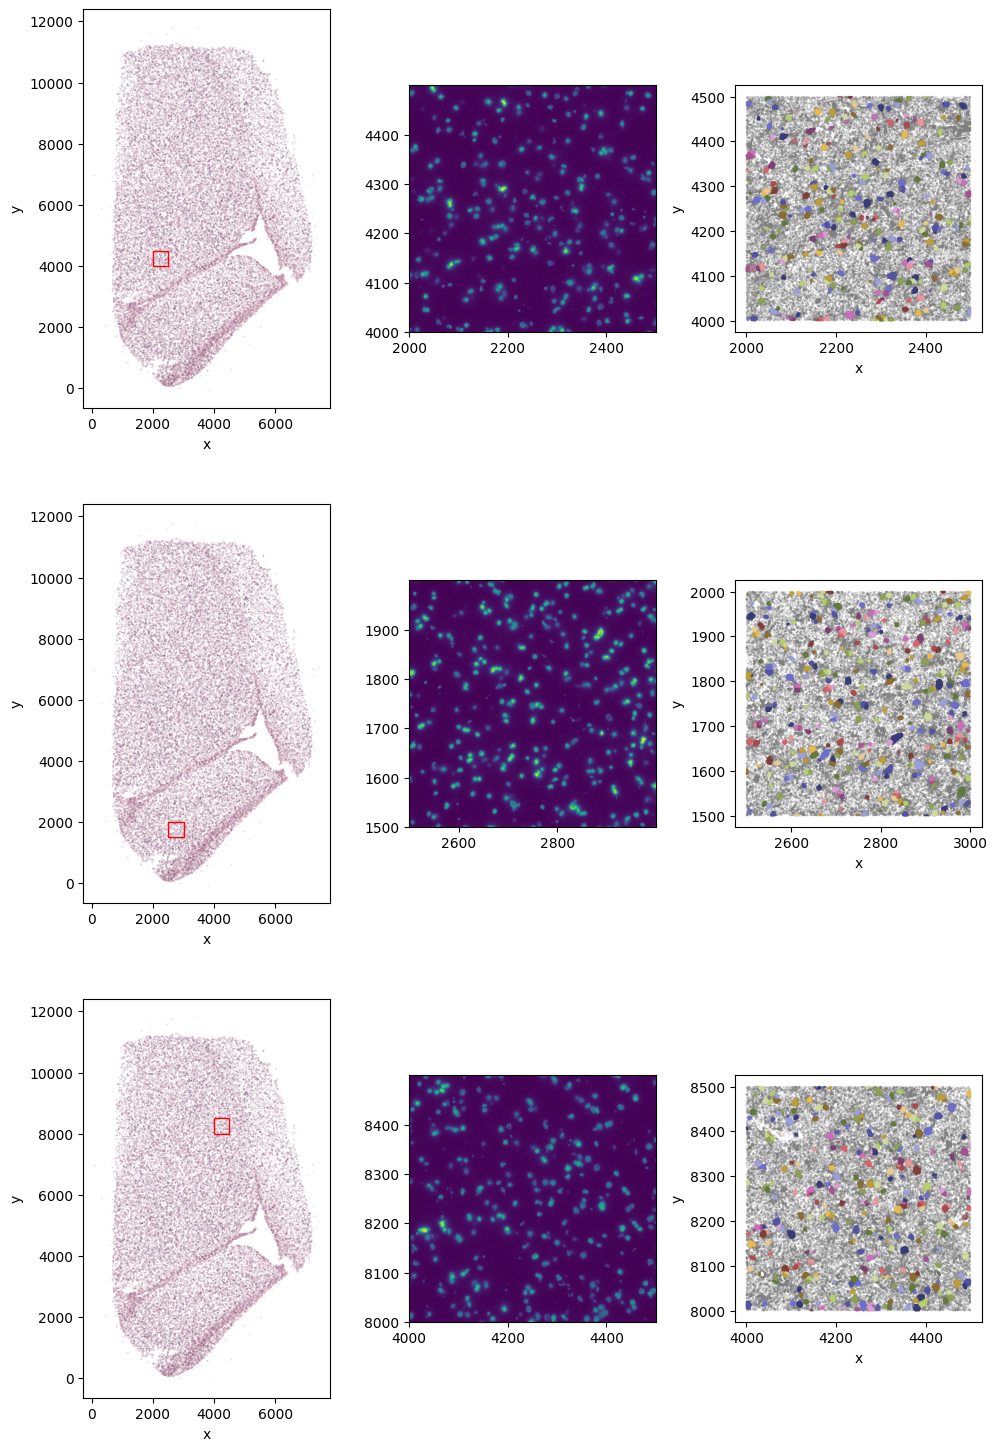

In [11]:
fig, ax = plt.subplots(ncols=3, nrows=len(subregions), figsize=(15, 5*len(subregions)))

for i, subregion in enumerate(subregions):
    spot_table[::1000].scatter_plot(ax[i, 0])
    sub_table = spot_table.get_subregion(xlim=subregion[0], ylim=subregion[1])
    sub_table.plot_rect(ax[i, 0], 'r')
    sub_table.get_image(channel='DAPI').show(ax=ax[i, 1])
    sub_table.scatter_plot(ax=ax[i, 2], color='cell')
    
plt.tight_layout()

3. Format anndata and QC cells  
- Calculate QC metrics and stick in obs  
    Current parameters for qc'ing include:  
    - '>' 8 genes
    - < 2% blanks
- Add probe type to var
    - also add whether the gene is one used for cell QC?
- Add log transformed layer
- Save updated cbg in main directory as sp_ad to follow previous workflow

In [12]:
import numpy as np
gene_cols = [col for col in cbg.var_names if not col.startswith('Blank')]
blank_cols = [col for col in cbg.var_names if col.startswith('Blank')]
cbg.obs['n_transcripts'] = np.sum(cbg[:, gene_cols].X, axis=1)
cbg.obs['n_genes'] = np.sum(cbg[:,gene_cols].X > 0, axis=1)
cbg.obs['n_blanks'] = np.sum(cbg[:, blank_cols].X, axis=1)
cbg.obs['perc_blanks'] = cbg.obs['n_blanks'] / cbg.obs['n_transcripts'] * 100
cbg.obs.replace(to_replace={'perc_blanks': {np.inf: 100}}, inplace=True)

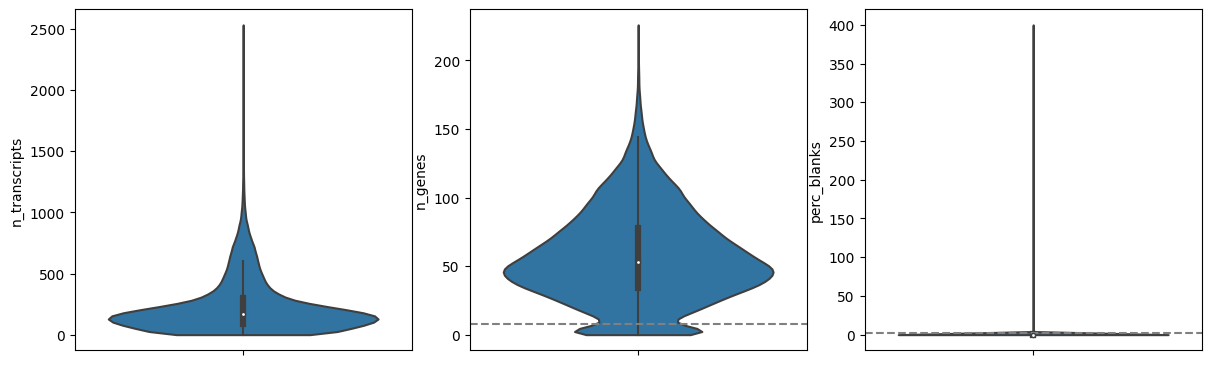

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
plt.tight_layout()

sns.violinplot(data=cbg.obs, y='n_transcripts', cut=0, ax=ax[0])
sns.violinplot(data=cbg.obs, y='n_genes', cut=0, ax=ax[1])
ax[1].axhline(8, color='grey', ls='--')
sns.violinplot(data=cbg.obs, y='perc_blanks', cut=0, ax=ax[2])
ax[2].axhline(2, color='grey', ls='--')

In [39]:
cbg.obs.describe()

x             y  n_transcripts       n_genes      n_blanks  \
count  66009.000000  66009.000000   66009.000000  66009.000000  66009.000000   
mean    3586.489502   5944.679199     254.036025     61.565105      1.025709   
std     1657.246338   2922.950439     227.806124     32.790183      1.460896   
min      361.989868    -60.927124       0.000000      0.000000      0.000000   
25%     2206.430664   3486.849365     110.000000     39.000000      0.000000   
50%     3489.872559   5896.309570     183.000000     57.000000      1.000000   
75%     4881.098145   8426.953125     321.000000     82.000000      2.000000   
max     7741.764160  11548.279297    3636.000000    227.000000     26.000000   

        perc_blanks  
count  66009.000000  
mean       0.452101  
std        1.620776  
min        0.000000  
25%        0.000000  
50%        0.155763  
75%        0.613497  
max      100.000000

In [14]:
cbg.obs['min_gene_qc'] = cbg.obs.apply(lambda x: x['n_genes'] > 8, axis=1)
cbg.obs['perc_blanks_qc'] = cbg.obs.apply(lambda x: x['perc_blanks'] < 2, axis=1)

Text(0.5, 1.0, 'Remaining Cells: 73055')

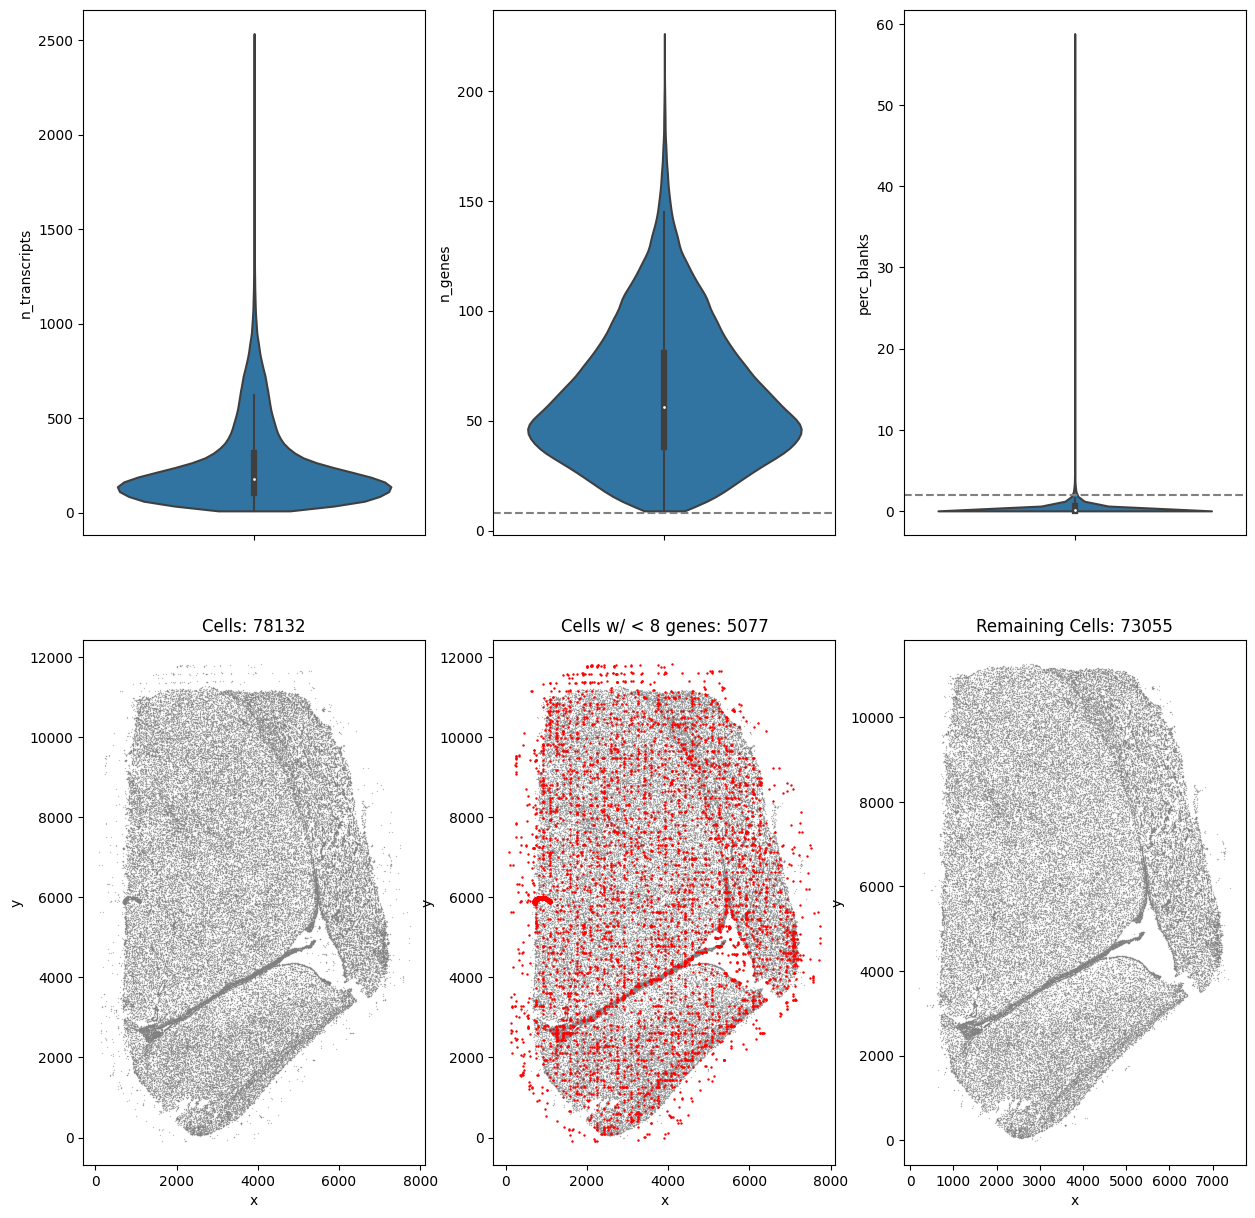

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(15, 15))

cbg_filt = cbg.obs[cbg.obs['min_gene_qc']]

sns.violinplot(data=cbg_filt, y='n_transcripts', cut=0, ax=ax[0, 0])
sns.violinplot(data=cbg_filt, y='n_genes', cut=0, ax=ax[0, 1])
ax[0, 1].axhline(8, color='grey', ls='--')
sns.violinplot(data=cbg_filt, y='perc_blanks', cut=0, ax=ax[0, 2])
ax[0, 2].axhline(2, color='grey', ls='--')

sns.scatterplot(data=cbg.obs, x='x', y='y', color='grey', s=1, alpha=0.5, ax=ax[1, 0], linewidth=0)
ax[1, 0].set_title(f'Cells: {len(cbg.obs)}')
sns.scatterplot(data=cbg.obs, x='x', y='y', color='grey', s=1, alpha=0.5, ax=ax[1, 1], linewidth=0)
sns.scatterplot(data=cbg.obs[~cbg.obs['min_gene_qc']], x='x', y='y', color='red', s=3, ax=ax[1, 1], linewidth=0)
ax[1, 1].set_title(f'Cells w/ < 8 genes: {len(cbg.obs) - len(cbg_filt)}')
sns.scatterplot(data=cbg_filt, x='x', y='y', color='grey', s=1, alpha=0.5, ax=ax[1, 2], linewidth=0)
ax[1, 2].set_title(f'Remaining Cells: {len(cbg_filt)}')

Text(0.5, 1.0, 'Remaining Cells: 70908')

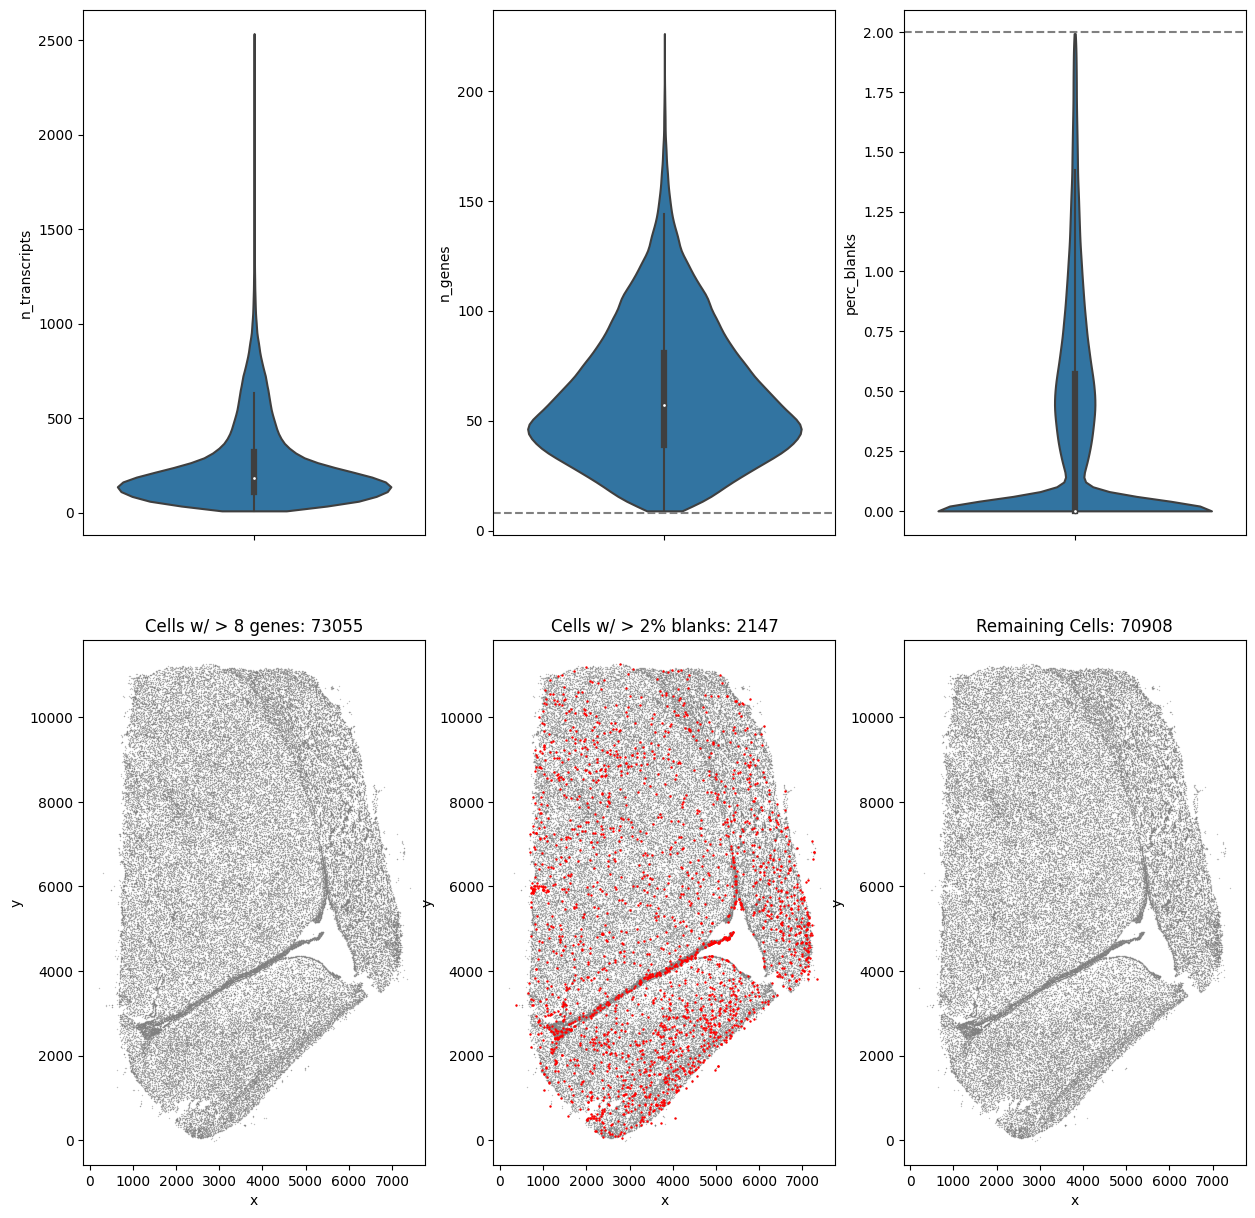

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(15, 15))

cbg_filt2 = cbg_filt[cbg_filt['perc_blanks_qc']]

sns.violinplot(data=cbg_filt2, y='n_transcripts', cut=0, ax=ax[0, 0])
sns.violinplot(data=cbg_filt2, y='n_genes', cut=0, ax=ax[0, 1])
ax[0, 1].axhline(8, color='grey', ls='--')
sns.violinplot(data=cbg_filt2, y='perc_blanks', cut=0, ax=ax[0, 2])
ax[0, 2].axhline(2, color='grey', ls='--')

sns.scatterplot(data=cbg_filt, x='x', y='y', color='grey', s=1, alpha=0.5, ax=ax[1, 0], linewidth=0)
ax[1, 0].set_title(f'Cells w/ > 8 genes: {len(cbg_filt)}')
sns.scatterplot(data=cbg_filt, x='x', y='y', color='grey', s=1, alpha=0.5, ax=ax[1, 1], linewidth=0)
sns.scatterplot(data=cbg_filt[~cbg_filt['perc_blanks_qc']], x='x', y='y', color='red', s=3, ax=ax[1, 1], linewidth=0)
ax[1, 1].set_title(f'Cells w/ > 2% blanks: {len(cbg_filt) - len(cbg_filt2)}')
sns.scatterplot(data=cbg_filt2, x='x', y='y', color='grey', s=1, alpha=0.5, ax=ax[1, 2], linewidth=0)
ax[1, 2].set_title(f'Remaining Cells: {len(cbg_filt2)}')

In [17]:
cbg.var['probe_type'] = None
cbg.var['probe_type'] = cbg.var.apply(lambda x: 'blank' if x.name.startswith('Blank') else 'gene', axis=1)

In [18]:
cbg.layers['logcounts'] = np.log1p(cbg.X)

In [24]:
import pickle
meta_file = merscope_section.segmentation_path.joinpath('20231130_135123/metadata.pkl')
with open(meta_file, 'rb') as f:
    seg_meta = pickle.load(f)
    f.close()

In [25]:
seg_meta

{'dt_file': WindowsPath('//allen/programs/celltypes/production/mfish/mfishmerscopemacaqueatlas/1291814104/region_0/detected_transcripts.csv'),
 'image_path': WindowsPath('//allen/programs/celltypes/production/mfish/mfishmerscopemacaqueatlas/1291814104/region_0/images'),
 'output_dir': WindowsPath('//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/macaque/1291814104/segmentation/20231130_135123'),
 'dt_cache': WindowsPath('//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/macaque/1291814104/detected_transcripts.npz'),
 'subrgn': 'DAPI',
 'seg_method': sawg.segmentation.CellposeSegmentationMethod,
 'seg_opts': {'options': {'region': None,
   'cellpose_model': '/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/models/cellpose_20230919_3species_merscope',
   'cellpose_gpu': 'auto',
   'px_size': 0.108,
   'cell_dia': 10,
   'z_plane_thickness': 1.5,
   'images': {'cyto': {'channel': 'total_mrna', 'n_planes': 7},

In [26]:
cbg.obs['cell_qc'] = cbg.obs.apply(lambda x: 'pass' if x['min_gene_qc'] and x['perc_blanks_qc'] else 'fail', axis=1)
cbg.uns.update(
{
    'qc': {'genes': '> 8', 'perc_blanks': '< 2%'},
    'segmentation': {'method_class': str(seg_meta['seg_method']), 'method_args': seg_meta['seg_opts']}
}
)

In [27]:
cbg.uns

OrderedDict([('qc', {'genes': '> 8', 'perc_blanks': '< 2%'}),
             ('segmentation',
              {'method_class': "<class 'sawg.segmentation.CellposeSegmentationMethod'>",
               'method_args': {'options': {'region': None,
                 'cellpose_model': '/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/models/cellpose_20230919_3species_merscope',
                 'cellpose_gpu': 'auto',
                 'px_size': 0.108,
                 'cell_dia': 10,
                 'z_plane_thickness': 1.5,
                 'images': {'cyto': {'channel': 'total_mrna', 'n_planes': 7},
                  'nuclei': {'channel': 'DAPI'}},
                 'cellpose_options': {'batch_size': 8, 'min_size': 5000}}}})])

In [28]:
sp_anndata_path = merscope_section.save_path.joinpath('sp_anndata.h5ad')
cbg.write_h5ad(sp_anndata_path)
merscope_section.anndata_file = sp_anndata_path
merscope_section.save_dataset()

4. Map with ScrattchMapping
- Create ScrattchMapping object
- Flag to only map QC pass cells? (ie ad_map will only have qc_pass cells but original cbg is retained)

In [5]:
map_args = {'ad_sp_layer': 'logcounts', 'cell_qc': 'cell_qc'}
hpc_args = {'docker': 'singularity exec --cleanenv docker://njjai/scrattch_mapping:0.51'}

job, mapping = merscope_section.run_mapping_on_section(ScrattchMapping, 'AIT115', method_args=map_args, hpc_args=hpc_args)

loading spatial data from \\allen\programs\celltypes\workgroups\rnaseqanalysis\NHP_spatial\MERSCOPE\macaque\1291814104\sp_anndata.h5ad...
Setting run directory to //allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/macaque/1291814104/mapping
Mapping UID: 1701975246.819
building HPC job
<JobState RUNNING> 13569752


In [6]:
job.state()

<JobState RUNNING>

5. Do some basic analysis and make some plots
- Mapping probability distributions
- Mapping scatter plots, cluster level grouped by neighborhood
- Make cirro object for interactive viewing locally?

In [5]:
merscope_section.get_mappings()

1700074043.523: {'mapping_method': 'scrattch mapping', 'taxonomy': '//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/10x_seq/NHP_BG_AIT_115', 'sp_data_uns': '{\'qc\': {\'genes\': \'> 8\', \'perc_blanks\': \'< 2%\'}, \'segmentation\': {\'method_args\': {\'options\': {\'cell_dia\': 10, \'cellpose_gpu\': \'auto\', \'cellpose_model\': \'/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/models/cellpose_20230919_3species_merscope\', \'cellpose_options\': {\'batch_size\': 8}, \'images\': {\'cyto\': {\'channel\': \'total_mrna\', \'frame\': 3, \'n_planes\': 7}, \'nuclei\': {\'channel\': \'DAPI\', \'frame\': 3}}, \'px_size\': 0.108, \'z_plane_thickness\': 1.5}}, \'method_class\': "<class \'sawg.segmentation.CellposeSegmentationMethod\'>"}}', 'counts': 'logcounts'}
1700174275.071: {'mapping_method': 'scrattch mapping', 'taxonomy': '//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/10x_seq/NHP_BG_AIT_115', 'sp_data_uns': '{\'qc\': {\'genes\': \'> 8

loading results...
deleting scrattch-mapping temp file...
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


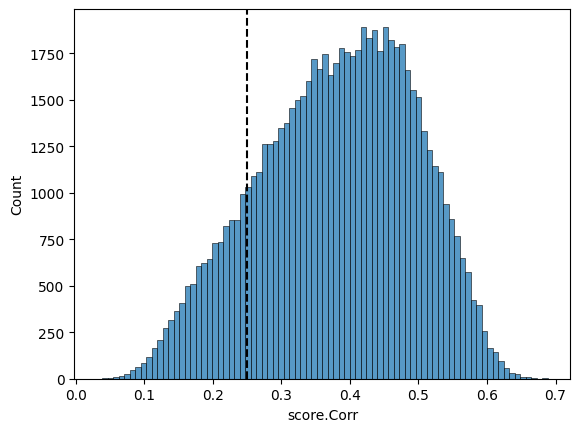

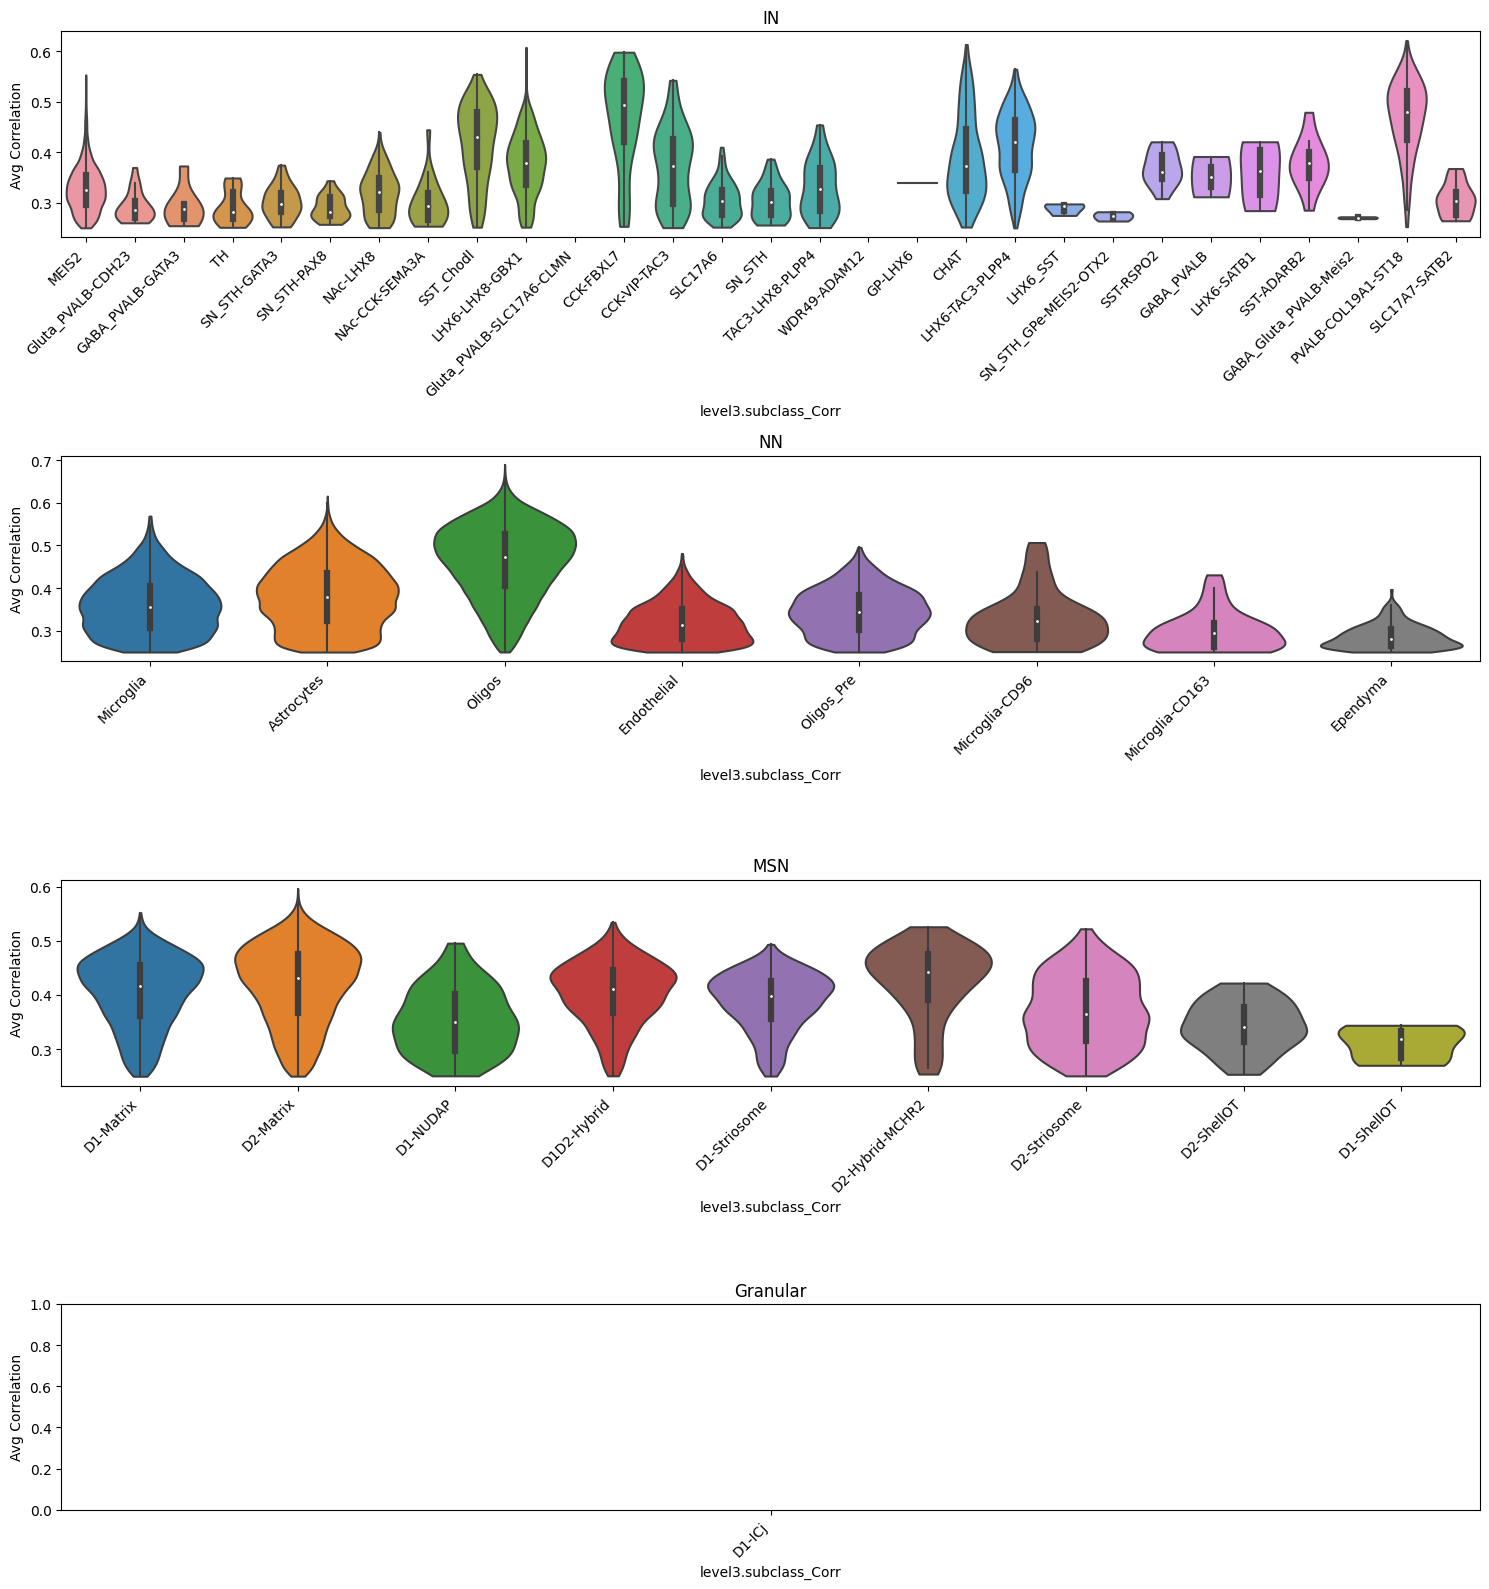

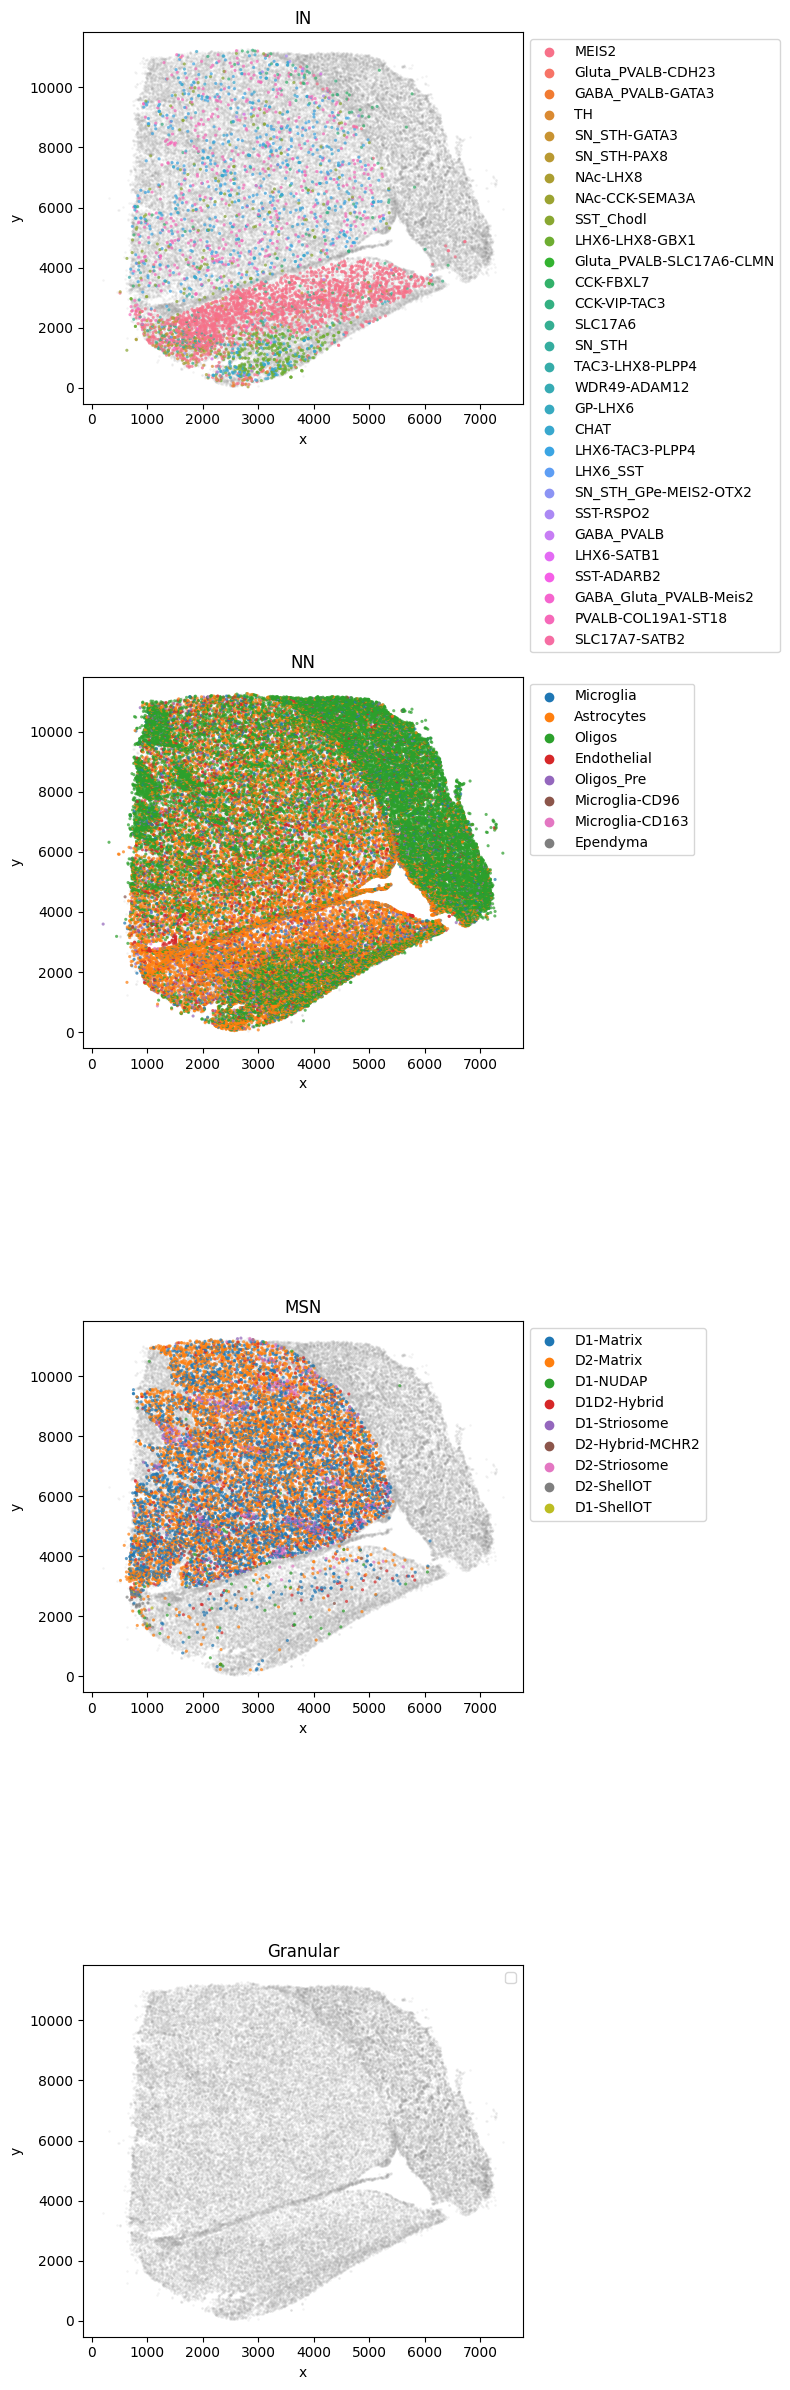

In [7]:
merscope_section.view_mapping_results(mapping, 'subclass', score_thresh=0.25)

Make Cirro files for viewing (optional)  
Run `cirro launch [cirro_file]` from commmand window

In [4]:
cirro_file = merscope_section.make_cirro('1701975246.819')

loading results...
No scrattch_map_temp.h5ad file found in run directory, checking for previously saved results...
\\allen\programs\celltypes\workgroups\rnaseqanalysis\NHP_spatial\MERSCOPE\macaque\1291814104\mapping\1701975246.819\ad_cirro_QM23.50.001.CX.44.01.05.03.h5ad
